## Basic library to import

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.colors import LogNorm
from matplotlib.ticker import LogLocator, NullFormatter
import pandas as pd
from scipy.linalg import lu_factor, lu_solve
from scipy import optimize
from scipy.constants import mu_0, epsilon_0
from scipy.special import roots_legendre
from scipy.interpolate import InterpolatedUnivariateSpline as iuSpline

## Specific library to import

In [2]:
import discretize
import empymod


## Project package to import

In [3]:
import Project
from Project import EMIP1D

Configuration is inspired by JOGMEC WISTEM survey  
In this case I am using bipole so excactly as 3.5m rectangular loop  
K.Nakayama(2019)  

In [4]:
t = np.logspace(-8,-2, 121)
tstrt = 1e-6
tend = 1e-2
tindex = (t >= tstrt) & (t <= tend)
tplot = t[tindex]

In [5]:
res_air = 2e14
res_sea = 1/3
nlayers = 5
layer_thicknesses = 5
seabed_depth = 1000.1

btm_fix = False
depth = np.hstack([np.r_[0],seabed_depth+layer_thicknesses * np.arange(nlayers)])

In [6]:

model_base = {
    'src':  [1.75,1.75,-1.75,1.75,1000, 1000],
    'rec': [0,0,1000,0,90],
    'depth': depth,
    'freqtime': t ,
    'signal': 0,
    'mrec' : True,
    'verb': 0
}

In [7]:
EMIP =  EMIP1D("cole",model_base,res_air,res_sea,nlayers,tindex)

In [8]:
res0 = 1/10 * np.ones(nlayers)
mvec_r0 = np.log(res0)
res8 = 1/10* np.ones(nlayers)
mvec_r8 = np.log(res8)
mvec_t = np.log(1e-4)*np.ones(nlayers)
mvec_c = 0.5*np.ones(nlayers)
mvec_obs = np.hstack([mvec_r0, mvec_r8, mvec_t, mvec_c])
data_clean = EMIP.predicted_data(mvec_obs)

In [9]:
model_obs = EMIP.get_ip_model(mvec_obs)
np.set_printoptions(formatter={'float': lambda x: "{:.2e}".format(x)})
print(f'{model_obs["res"]:}')
print(f'{1-model_obs["cond_0"]/model_obs["cond_8"]}')
print(f'{model_obs["tau"]}')
print(f'{model_obs["c"]}')

[2.00e+14 3.33e-01 1.00e-01 1.00e-01 1.00e-01 1.00e-01 1.00e-01]
[0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00]
[1.00e-03 1.00e-03 1.00e-04 1.00e-04 1.00e-04 1.00e-04 1.00e-04]
[0.00e+00 0.00e+00 5.00e-01 5.00e-01 5.00e-01 5.00e-01 5.00e-01]


In [10]:
relative_error=0.01
np.random.seed(0)
data_obs =  data_clean + np.random.randn(len(data_clean)) * relative_error * np.abs(data_clean)

Prepare initial model

In [11]:
res0 = 1 * np.ones(nlayers)
mvec_r0 = np.log(res0)
res8 = 1 * np.ones(nlayers)
mvec_r8 = np.log(res8)
mvec_t = np.log(1e-3)*np.ones(nlayers)
mvec_c = 0.6*np.ones(nlayers)
mvec_init = np.hstack([mvec_r0, mvec_r8, mvec_t, mvec_c])
data_init = EMIP.predicted_data(mvec_init)

In [12]:
Wd = EMIP.get_Wd(dobs=data_obs,dp=0.01)
#Wd = np.diag(np.ones(len(data_obs)))
Ws = EMIP.get_Ws()
Wx = EMIP.get_Wx()

Inversion using GaussNewton method

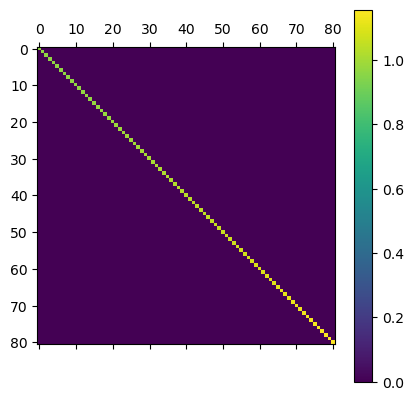

In [13]:
plt.colorbar(plt.matshow(Wd), norm=LogNorm())

In [25]:
niter = 2
beta = 1e-3
alphas = 1e-3
alphax = 1


# mvec_pred, error, model_itr = EMIP.GaussNewton_smooth(
#     dobs=data_obs, model_init=mvec_init, niter=niter, Wd =Wd,
#     beta=beta, Ws = Ws, Wx=Wx, alphas=alphas, alphax=alphax)
mvec_pred, error, model_itr = EMIP.GaussNewton_smooth(
    dobs=data_obs, model_init=mvec_SD, niter=niter, Wd =Wd,
    beta=beta, Ws = Ws, Wx=Wx, alphas=alphas, alphax=alphax)

Gauss-Newton 
 Initial phid = 7.98e+03 ,phim = 5.21e+00, error= 7.98e+03 
  1, step:1.95e-03, gradient:3.07e+05, phid:7.71e+03, phim:6.19e+00, f:7.71e+03 
  2, step:1.00e+00, gradient:1.78e+05, phid:7.27e+03, phim:1.05e+01, f:7.27e+03 


In [31]:
niter = 5
Wd = EMIP.get_Wd(dobs=data_obs,dp=1)
mvec_pred, error, model_itr = EMIP.GaussNewton_smooth(
    dobs=data_obs, model_init=mvec_pred, niter=niter, Wd =Wd,
    beta=beta, Ws = Ws, Wx=Wx, alphas=alphas, alphax=alphax)

Gauss-Newton 
 Initial phid = 8.84e+03 ,phim = 1.02e+01, error= 8.84e+03 
  1, step:9.54e-07, gradient:2.91e+04, phid:8.84e+03, phim:1.02e+01, f:8.84e+03 
  2, step:9.54e-07, gradient:2.92e+04, phid:8.84e+03, phim:1.02e+01, f:8.84e+03 
  3, step:9.54e-07, gradient:2.92e+04, phid:8.85e+03, phim:1.02e+01, f:8.85e+03 
  4, step:9.54e-07, gradient:2.92e+04, phid:8.85e+03, phim:1.02e+01, f:8.85e+03 
  5, step:9.54e-07, gradient:2.92e+04, phid:8.85e+03, phim:1.02e+01, f:8.85e+03 


In [21]:
data_pred = (EMIP.predicted_data(mvec_pred))

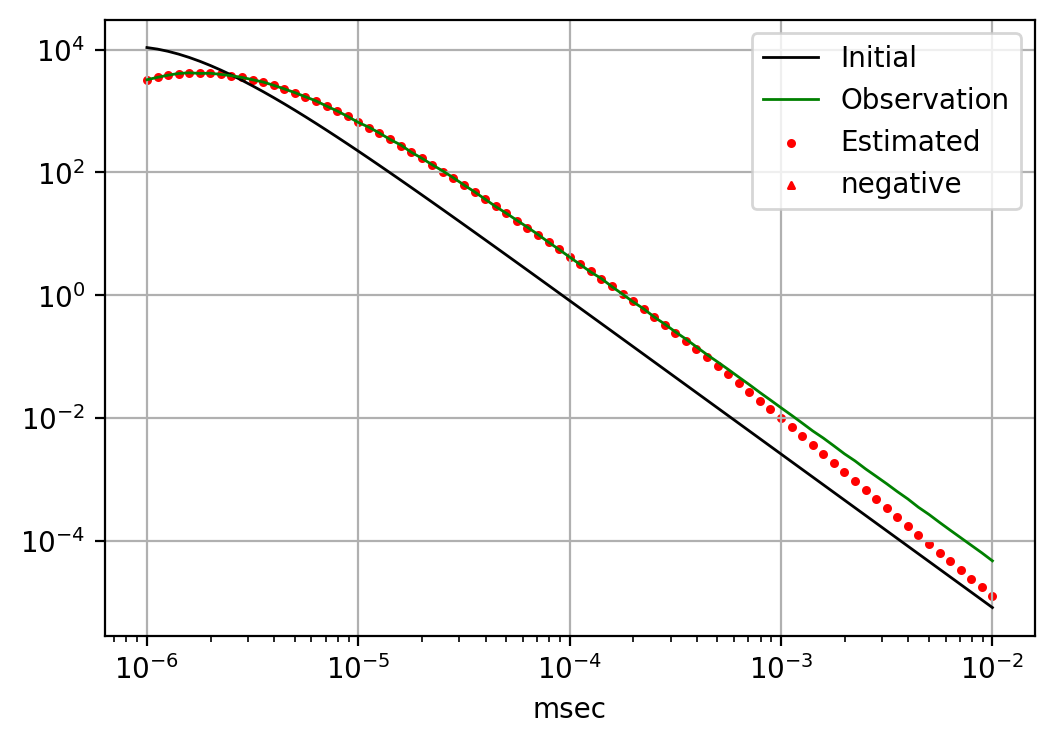

In [22]:
plt.figure(figsize=(6, 4),dpi=200)

plt.plot(tplot, data_init, "-", color="k", label="Initial", linewidth=1)
plt.plot(tplot, -data_init, "--", color="k", linewidth=1)

plt.plot(tplot, data_obs, "-", color="g", label="Observation", linewidth=1)
plt.plot(tplot, -data_obs, "--", color="g", linewidth=1)

plt.scatter(tplot, data_pred, color="r", label="Estimated", marker='o', s=5)
plt.scatter(tplot, -data_pred,  color="r", label="negative",marker='^', s=5)
plt.xlabel("msec")
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.grid()
plt.show()


In [23]:
model_init =  EMIP.get_ip_model(mvec_init)
model_obs  =  EMIP.get_ip_model(mvec_obs)
model_pred  =  EMIP.get_ip_model(mvec_pred)

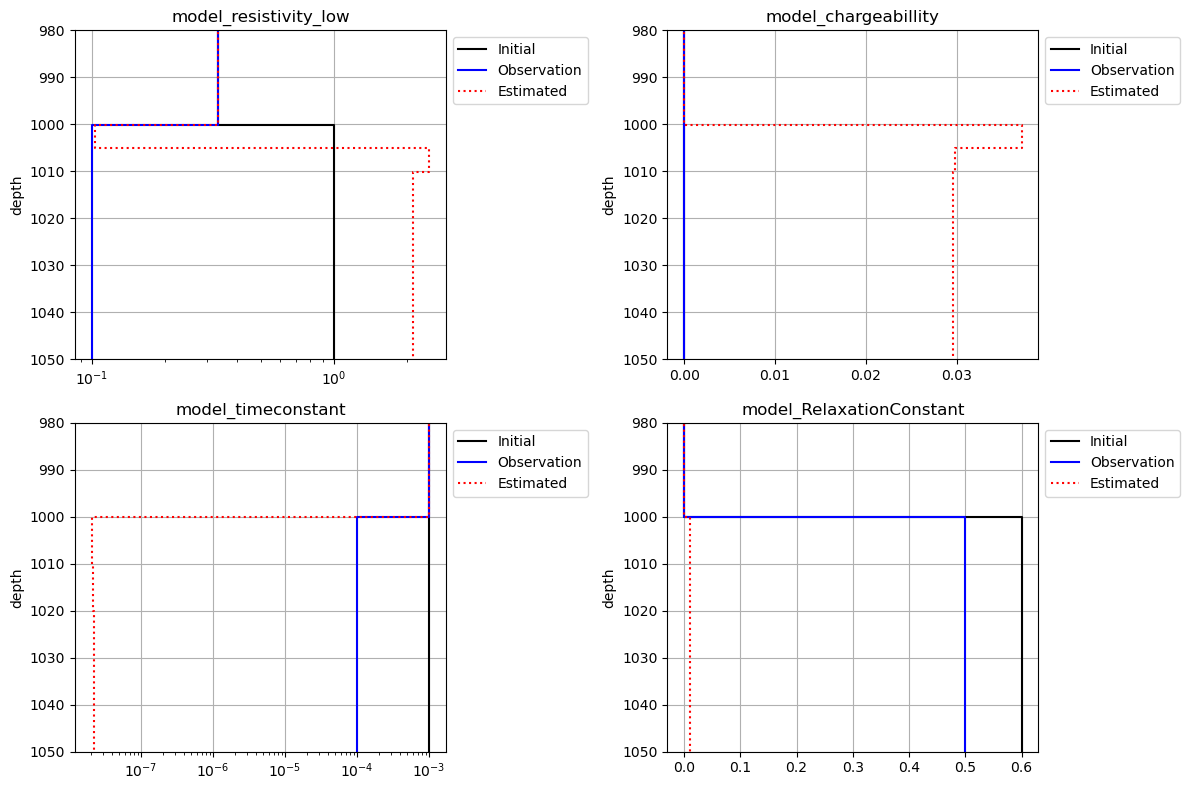

In [24]:
fig, ax = plt.subplots(2, 2, figsize=(12, 8))

#plot_model_m(model_base["depth"], model_ip["res"], ax[0], "resistivity","k")
EMIP.plot_model(model_init["res"], ax[0,0],"Initial","k-")
EMIP.plot_model(model_obs["res"] , ax[0,0],"Observation","b-")
EMIP.plot_model(model_pred["res"], ax[0,0],"Estimated","r:")

EMIP.plot_model((model_init["cond_8"]-model_init["cond_0"])/model_init["cond_8"], ax[0,1],"Initial","k-")
EMIP.plot_model((model_obs["cond_8"]-model_obs["cond_0"])/model_obs["cond_8"]  ,ax[0,1],"Observation","b-")
EMIP.plot_model((model_pred["cond_8"]-model_pred["cond_0"])/model_pred["cond_8"], ax[0,1],"Estimated","r:")

EMIP.plot_model(model_init["tau"], ax[1,0],"Initial","k-")
EMIP.plot_model(model_obs["tau"]  ,ax[1,0],"Observation","b-")
EMIP.plot_model(model_pred["tau"], ax[1,0],"Estimated","r:")
    
EMIP.plot_model(model_init["c"], ax[1,1],"Initial","k-")
EMIP.plot_model(model_obs["c"]  ,ax[1,1],"Observation","b-")
EMIP.plot_model(model_pred["c"], ax[1,1],"Estimated","r:")
    
    
ax[0,0].set_title("model_resistivity_low")
ax[0,1].set_title("model_chargeabillity")
ax[1,0].set_title("model_timeconstant")
ax[1,1].set_title("model_RelaxationConstant")

for i in range(2):  # Iterate over rows
    for j in range(2):  # Iterate over columns
        ax[i, j].set_ylim([1050, 980])
        ax[i, j].set_ylabel('depth')
        ax[i, j].legend(loc='upper left', bbox_to_anchor=(1, 1))
        ax[i, j].grid()
        if  j==0:
            ax[i, j].set_xscale("log")
            
plt.tight_layout()

In [16]:
niter = 3
mvec_SD, error, model_itr = EMIP.steepest_descent(dobs=data_obs,model_init=mvec_init,niter=niter)

Steepest Descent 
 initial phid= 8.909e+07 
 i=   0, phid= 5.604e+07 
 i=   1, phid= 1.383e+06 
 i=   2, phid= 8.568e+03 


In [17]:
data_SD = (EMIP.predicted_data(mvec_SD))

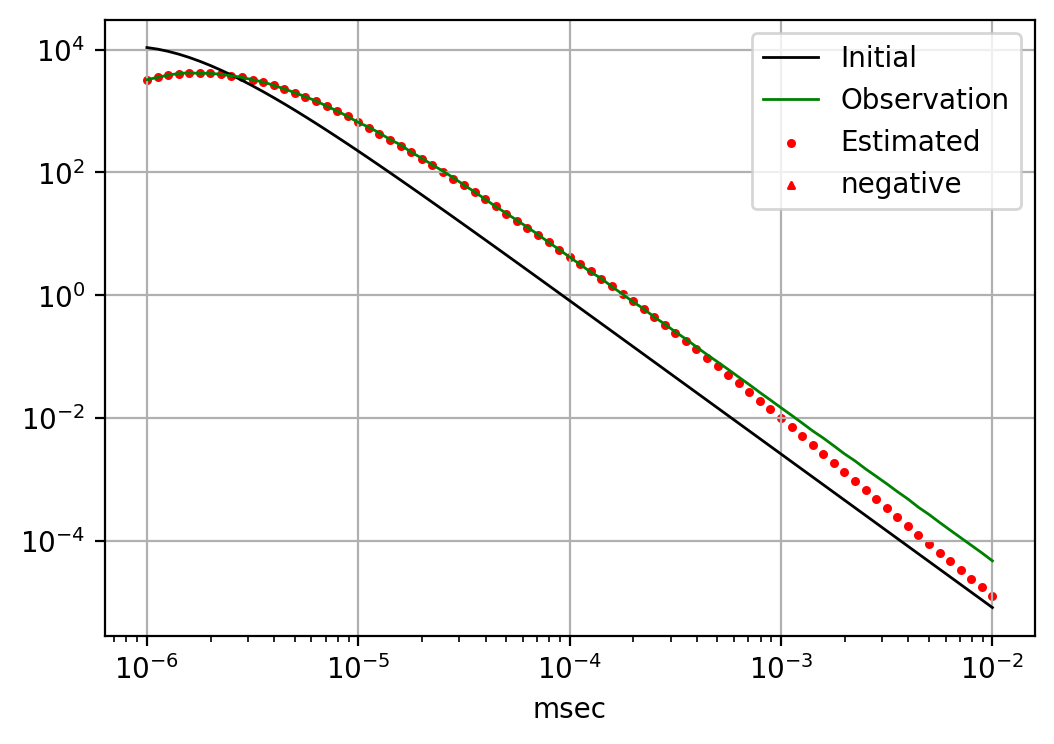

In [18]:
plt.figure(figsize=(6, 4),dpi=200)

plt.plot(tplot, data_init, "-", color="k", label="Initial", linewidth=1)
plt.plot(tplot, -data_init, "--", color="k", linewidth=1)

plt.plot(tplot, data_obs, "-", color="g", label="Observation", linewidth=1)
plt.plot(tplot, -data_obs, "--", color="g", linewidth=1)

plt.scatter(tplot, data_SD, color="r", label="Estimated", marker='o', s=5)
plt.scatter(tplot, -data_SD,  color="r", label="negative",marker='^', s=5)
plt.xlabel("msec")
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.grid()
plt.show()
